In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression,Ridge, Lasso 
from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [22]:
data = pd.read_excel("test.xlsx")
data.head()

,hour,date_miladi,date_shamsi,code,unit_no,fuel_type,mvar,temp,moisture,power
0,1,2020-01-13,1398/10/23,SO,1,A,11,3,94,119
1,2,2020-01-13,1398/10/23,SO,1,A,11,3,96,119
2,3,2020-01-13,1398/10/23,SO,1,A,10,2,95,120
3,4,2020-01-13,1398/10/23,SO,1,A,11,2,95,120
4,5,2020-01-13,1398/10/23,SO,1,A,11,2,95,121


In [23]:
data=data[data["power"]>100]
data.shape

(756, 10)

In [24]:
# Change object to integer:
data["fuel_type"][data["fuel_type"]=="A"] = 1; 
data["fuel_type"][data["fuel_type"]=="B"] = 2;
data["fuel_type"][data["fuel_type"]=="C"] = 3;

In [25]:
data['fuel_type'].value_counts()

1    508
Name: fuel_type, dtype: int64

In [26]:
data["fuel_type"].fillna(method='bfill', inplace=True)

In [27]:
data.isnull().sum()

hour           0
date_miladi    0
date_shamsi    0
code           0
unit_no        0
fuel_type      0
mvar           0
temp           0
moisture       0
power          0
dtype: int64

In [28]:
X = data[["moisture","unit_no","temp","fuel_type"]]
y = data[["power"]]
y

,power
0,119
1,119
2,120
3,120
4,121
...,...
994,110
995,127
996,127
997,124


In [29]:
X

,moisture,unit_no,temp,fuel_type
0,94,1,3,1
1,96,1,3,1
2,95,1,2,1
3,95,1,2,1
4,95,1,2,1
...,...,...,...,...
994,6,6,15,1
995,8,6,16,1
996,21,6,18,1
997,11,6,19,1


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [32]:
lr = LinearRegression() 
ridge = Ridge(alpha=1.0) 
lasso = Lasso(alpha=0.1) 
rf = RandomForestRegressor(n_estimators=100, max_depth=5) 
meta_model = LinearRegression()

In [33]:
param_grid_lr = {}
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0]}
param_grid_lasso = {'alpha': [0.1, 1.0, 10.0]}
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}

In [34]:
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5) 
grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5) 
grid_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5) 
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5)

In [35]:
grid_lr.fit(X_train, y_train) 
grid_ridge.fit(X_train, y_train) 
grid_lasso.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(max_depth=5),
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]})

In [36]:
base_models = [grid_lr.best_estimator_, grid_ridge.best_estimator_, grid_lasso.best_estimator_, grid_rf.best_estimator_]

In [37]:
stacked_model = StackingCVRegressor(regressors=base_models, meta_regressor=meta_model, cv=5)

In [38]:
stacked_model.fit(X_train, y_train)

StackingCVRegressor(meta_regressor=LinearRegression(),
                    regressors=[LinearRegression(), Ridge(alpha=10.0), Lasso(),
                                RandomForestRegressor(max_depth=5)])

In [39]:
y_pred = stacked_model.predict(X_test)

In [40]:
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 54.83543245681421
R-squared: 0.4487614177750482


# Trying dimension reduction

In [48]:
# Apply PCA to reduce the number of features to 3
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

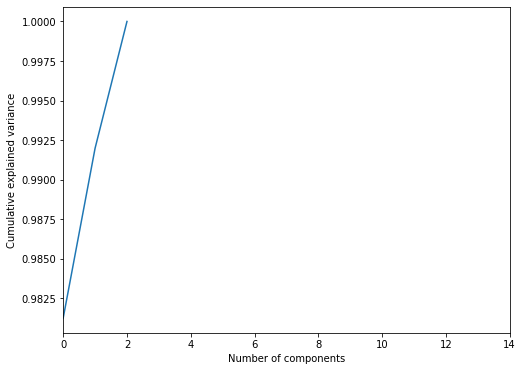

In [49]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,14,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

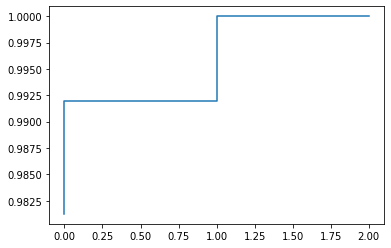

In [50]:
cumulative=np.cumsum(pca.explained_variance_ratio_)
plt.step([i for i in range(len(cumulative))],cumulative)
plt.show()

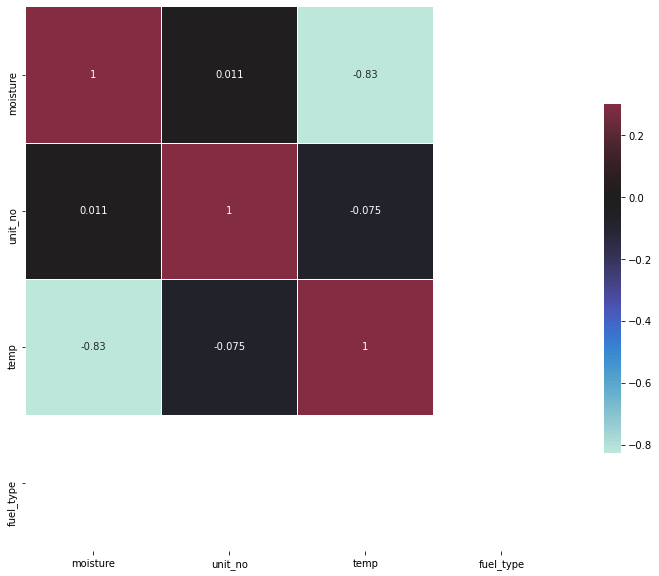

In [51]:
plt.figure(figsize=(10,10))
sns.heatmap(X_train.corr(),vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.tight_layout()
plt.show()

In [52]:
pca=PCA().fit(X_train)
print(pca.explained_variance_ratio_)
print()
print(X_train.columns.values.tolist())

[0.98211081 0.0100714  0.00781778 0.        ]

['moisture', 'unit_no', 'temp', 'fuel_type']


In [68]:
pipeline = Pipeline([
    ('pca', PCA(n_components=4)),
    ('st', StackingCVRegressor(regressors=base_models, meta_regressor=meta_model, cv=5))
])

In [69]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [70]:
# Calculate Mean Squared Error (MSE) of the predictions 
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 101.36513284057698
R-squared: -1.0891469418701383
